<a href="https://colab.research.google.com/github/kangmg/ModePerturbator/blob/main/notebooks/vib_perturb_pkg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install -q ase
%pip install -q torchani
%pip install -q git+https://github.com/Nilsgoe/mace_hessian.git
#%pip install -q mace-torch
%pip install -q git+https://github.com/isayevlab/AIMNet2.git
%pip install -q pointgroup
%pip install -q pymsym
%pip install -q git+https://github.com/kangmg/OverlayMol.git

# pyscf4ase
!wget https://raw.githubusercontent.com/kangmg/PySCF4ASE/main/setup.sh -O setup.sh
!chmod +x setup.sh
!./setup.sh

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 5.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 387.7/387.7 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.6/438.6 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 857.1 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
--2024-09-06 02:02:47--  https://raw.githubusercontent.com/kangmg/PySCF4ASE/main/setup.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108

In [ ]:
#@title modified pyscf4ase for hessian calc

from ase.calculators.calculator import Calculator, all_changes
from ase.units import Ha, Bohr
import torch
import pyscf
import numpy as np

class PySCFCalculator(Calculator):
    '''
    Description
    ===========
    PySCF ASE Calculator for dft caculations
    '''

    '''
    ===============
    Units
    ---------------
    Energy  eV
    Force   eV/Ang
    ===============
    '''


    implemented_properties = ['energy', 'forces', 'hessian']

    default_parameters = {
        'charge': 0, # system charge
        'spin': 0, # (= nelec alpha-beta = 2S)
        'symmetry': False, # point group symmetry : e.g. Cs or C2v Ref. https://github.com/pyscf/pyscf/blob/master/examples/gto/13-symmetry.py
        'basis': 'def2-tzvp', # basis set
        'xc': 'wb97m-d3bj', # xc functional
        'density_fit': True, # resolution of identity approximation
        'auxbasis': 'auto', # basis for density_fit : e.g. 'cc-pvdz-jkfit' or 'auto'(pyscf sets automatically)
        'device': 'auto', # gpu, cpu
        'disp': None, # dispersion correction : d3bj d4 d3 etc.
        'nlc': 'auto', # non-local correlation. :  0, 'auto', nlc-functional
        # [Note]
        # Set nlc to 0 when D3 and D4 dispersion corrections are applied
        # https://github.com/pyscf/pyscf/blob/master/examples/dft/15-nlc_functionals.py
        # https://github.com/pyscf/pyscf/blob/master/examples/dft/16-dft_d3.py
        'max_cycle': 50, # max number of iterations
        'conv_tol': 1e-9, # converge threshold
        'verbose' : 4, # output log level
        'max_memory': 150000, # MB unit
        'chkfile': None, # chkpoint file contains MOs, orbital energies etc. : (str) e.g. './checkpoint/pyscf.chk'
        'output': None, # log file : (str) e.g. './output/pyscf_output.log'
        # TODO : conv_tol_grad, init_guess
    }

    def _set_device(self):
        # set device
        if self.parameters.device == 'auto':
            self.parameters.device = 'gpu' if torch.cuda.is_available() else 'cpu'
        # import modules : dft
        if self.parameters.device == 'cpu':
            from pyscf import dft
            self.dft = dft
        elif self.parameters.device == 'gpu':
            from gpu4pyscf import dft
            self.dft = dft
        else:
            raise ValueError(f"Invalid device: {self.parameters.device}, 'gpu' or 'cpu' supported.")

    def __init__(self, restart=None, label='PySCF', **kwargs):
        super().__init__(restart=restart, label=label, **kwargs)
        self.mol = None
        self.mf = None

    def calculate(self, atoms=None, properties=['energy'], system_changes=all_changes):
        super().calculate(atoms, properties, system_changes)

        self._set_device()

        if self.atoms is None:
            raise ValueError("atoms object is not set.")

        if system_changes:
            self.results.clear()
            self.mol = None
            self.mf = None

        if self.mol is None:
            self._generate_molecule()

        if self.mf is None:
            self._run_dft()

        if 'energy' in properties and 'energy' not in self.results:
            self.results['energy'] = self.mf.e_tot * Ha

        if 'forces' in properties and 'forces' not in self.results:
            self.results['forces'] = self._calculate_forces() * Ha / Bohr

        if 'hessian' in properties and 'hessian' not in self.results:
            self.results['hessian'] = self._calculate_hessian() * Ha / (Bohr**2)

    def _generate_molecule(self):
        positions = self.atoms.get_positions()
        symbols = self.atoms.get_chemical_symbols()
        atom_str = "; ".join([f"{s} {p[0]} {p[1]} {p[2]}" for s, p in zip(symbols, positions)])
        self.mol = pyscf.M(atom=atom_str,
                         basis=self.parameters.basis,
                         charge=self.parameters.charge,
                         spin=self.parameters.spin,
                         symmetry=self.parameters.symmetry,
                         verbose = self.parameters.verbose,
                         max_memory=self.parameters.max_memory,
                         output=self.parameters.output,
                         unit='Angstrom')


    def _run_dft(self):
        self.mf = self.dft.RKS(self.mol)
        self.mf.xc = self.parameters.xc
        self.mf.max_cycle = self.parameters.max_cycle
        self.mf.conv_tol = self.parameters.conv_tol
        self.mf.disp = self.parameters.disp

        # checkpoint file : default is /tmp
        if self.parameters.chkfile:
            self.mf.chkfile = self.parameters.chkfile

        # non-local correlation
        if self.parameters.nlc != 'auto':
            self.mf.nlc = self.parameters.nlc

        # density_fit ( or resolution of identity (RI) approximation)
        if self.parameters.density_fit:
            if self.parameters.auxbasis == 'auto':
                self.mf.density_fit()
            elif self.parameters.auxbasis != 'auto':
                self.mf.density_fit(auxbasis=self.parameters.auxbasis)

        self.mf.kernel()

    def _calculate_forces(self):
        return -self.mf.nuc_grad_method().kernel()

    def _calculate_hessian(self):
        hessian = self.mf.Hessian().kernel()
        return hessian

    def get_hessian(self):
        """
        Calculate and return the Hessian matrix.

        Returns:
        --------
        hessian : numpy.ndarray
            The Hessian matrix with shape (3N, 3N) where N is the number of atoms.
            Units are in eV/Ang^2.
        """
        if 'hessian' not in self.results:
            self.calculate(properties=['hessian'])
        return self.results['hessian']

In [3]:
#@title setup

from torchani.utils import hessian
from ase.build import molecule
import torchani
from torchani.utils import vibrational_analysis, get_atomic_masses
import torch
from mace.calculators import mace_off
import ase
from aimnet2calc import AIMNet2Calculator
import warnings
import numpy as np
import pymsym
from pointgroup import PointGroup
from ase.io import read, write
import os
from overlaymol import OverlayMolecules

torch.set_printoptions(precision=6, sci_mode=False)
np.set_printoptions(precision=6, suppress=True)

warnings.filterwarnings('ignore')

In [4]:
#@title Hessian calculators

_cached_models = {}

def ani_hessian(atoms:ase.Atoms, model:str='ANI2x'):
    """
    Get Hessian using TorchANI calculator.

    Parameters
    ----------
    atoms : ase.Atoms
        The atomic structure for which the Hessian matrix will be calculated.
    model : str, optional
        The TorchANI model to use. Options are ['ANI2x', 'ANI1x', 'ANI1ccx'].
        Default is 'ANI2x'.

    Returns
    -------
    hess : torch.Tensor
        The Hessian matrix as a torch tensor.
    """

    def _atoms2ani(atoms:ase.Atoms):
        """Convert ASE Atoms to TorchANI format."""
        species = torch.tensor([atoms.get_atomic_numbers()], dtype=torch.long)
        positions = torch.tensor(
            [atoms.get_positions()],
            dtype=torch.float32,
            requires_grad=True
        )
        return species, positions

    if model not in _cached_models:
        _cached_models[model] = getattr(torchani.models, model)(periodic_table_index=True)
        _cached_models[model].eval()

    ani_model = _cached_models[model]
    ani_input = _atoms2ani(atoms)
    energy = ani_model(ani_input).energies

    hess = hessian(
        coordinates = ani_input[1],
        energies = ani_model(ani_input).energies
        )
    return hess



def mace_hessian(atoms:ase.Atoms, model:str='large'):
    """
    Get Hessian using MACE calculator.

    Parameters
    ----------
    atoms : ase.Atoms
        The atomic structure for which the Hessian matrix will be calculated.
    model : str, optional
        The MACE model to use. Options are ['small', 'medium', 'large'].
        Default is 'large'.

    Returns
    -------
    hess : torch.Tensor
        The Hessian matrix as a torch tensor.
    """
    if model not in _cached_models:
        _cached_models[model] = mace_off(
            model=model,
            device='cpu',
            default_dtype='float64'
        )

    mace_model = _cached_models[model]

    mace_hess = mace_model.get_hessian(atoms=atoms)

    return torch.tensor(mace_hess).reshape(1, len(atoms) * 3, -1)


def aimnet2_hessian(atoms:ase.Atoms, model:str='aimnet2', charge=0, mult=1):
    """
    Get Hessian using AIMNet2 calculator.

    Parameters
    ----------
    atoms : ase.Atoms
        The atomic structure for which the Hessian matrix will be calculated.
    model : str, optional
        The AIMNet2 model to use. Options are ['aimnet2'].
        Default is 'aimnet2'.
    charge : int, optional
        The charge of the system. Default is 0.
    mult : int, optional
        The multiplicity of the system. Default is 1.

    Returns
    -------
    hess : torch.Tensor
        The Hessian matrix as a torch tensor.
    """
    if model not in _cached_models:
        _cached_models[model] = AIMNet2Calculator(model=model)

    aimnet2_model = _cached_models[model]

    aimnet2_hess = aimnet2_model(
        data= {
            'coord':torch.tensor(atoms.get_positions()),
            'numbers':torch.tensor(atoms.get_atomic_numbers()),
            'charge':torch.tensor([charge]),
            'mult':torch.tensor([mult])
            },
        forces=True,
        hessian=True
    )['hessian']

    return aimnet2_hess.reshape(1, len(atoms) * 3, -1)


def pyscf_hessian(atoms:ase.Atoms, **calculator_kwargs):
    """
    Get Hessian using PySCF DFT calculator.

    Parameters
    ----------
    atoms : ase.Atoms
        The atomic structure for which the Hessian matrix will be calculated.
    **calculator_kwargs
        Additional keyword arguments to pass to the PySCF calculator.
        - charge (int): The charge of the system.
        - spin (int): The spin of the system.
        - basis (str): The basis set to use.
        - xc (str): The exchange-correlation functional to use.
        - etc

    Returns
    -------
    hess : torch.Tensor
        The Hessian matrix as a torch tensor.
    """

    calc = PySCFCalculator(**calculator_kwargs)
    calc.parameters.verbose = 0
    calc.atoms = atoms

    hess = calc.get_hessian().transpose(0, 2, 1, 3).reshape(1, len(atoms) * 3, -1)

    return torch.tensor(hess)

In [5]:
#@title custum functions
#@markdown mace랑 torchani, aimnet2, pyscf 단위 확인해야 함
#@markdown
#@markdown vibrational filter에서 음수나 복소수인 것들이 필터링됨 --> 고민

## mace랑 torchani, aimnet2 단위 확인해야 함


def atoms2pointgroup(atoms:ase.Atoms, engine='both'):
    """get point group from ase.Atoms
    """
    if engine == 'both':
        pymsym_pg = pymsym.get_point_group(
            positions=atoms.get_positions(),
            atomic_numbers=atoms.get_atomic_numbers()
            )
        pointgroup_pg = PointGroup(
            positions=atoms.get_positions(),
            symbols=atoms.get_chemical_symbols(),
            tolerance_eig=0.01,
            tolerance_ang=4
            ).get_point_group()

        if pymsym_pg == pointgroup_pg:
            return pymsym_pg
        else:
            raise Exception("two pg is not same")
    elif engine == 'pymsym':
        return pymsym.get_point_group(
            positions=atoms.get_positions(),
            atomic_numbers=atoms.get_atomic_numbers()
            )
    elif engine == 'pointgroup':
        return PointGroup(
            positions=atoms.get_positions(),
            symbols=atoms.get_chemical_symbols(),
            tolerance_eig=0.01,
            tolerance_ang=4
            ).get_point_group()
    else:
        raise Exception("engine is not supported")


def is_linear(pointgroup:str)->bool:
    """check if pointgroup is linear
    """
    linear_group = ['Cinfv', 'Dinfh']
    if pointgroup in linear_group:
        return True
    else:
        return False

def vibration_filter(atoms:ase.Atoms, VibAnalysis):
    """
    Filters translational & rotational modes based on the eigenvalues
    Get only vibrationl modes from analysis results.
    """
    pg = atoms2pointgroup(atoms)

    linear_molecule = is_linear(pg)

    # 3N - 5(6), num of vibrations
    degree_of_freedom = len(atoms) * 3
    if linear_molecule:
        N_vibs = degree_of_freedom - 5
    else:
        N_vibs = degree_of_freedom - 6

    freqs = torch.nan_to_num(VibAnalysis.freqs, 0)
    modes = VibAnalysis.modes

    # filter translational & rotational modes
    vib_idx = torch.argsort(freqs, descending=True)[:N_vibs]
    vib_modes = modes[vib_idx]
    vib_freqs = freqs[vib_idx]

    return vib_freqs, vib_modes


def atoms2normal_modes(
    atoms:ase.Atoms,
    engine='torchani',
    mode_type:str='MWN',
    **engine_kwargs
    ):
    """
    Normal modes analyzer

    Parameters
    ----------
    atoms : ase.Atoms
        The atomic structure for which the Hessian matrix will be calculated.
    engine : str
        The engine to use. Options are ['torchani', 'mace', 'aimnet2', 'pyscf'].
    mode_type : str
        Type of normal mode ( mass weigth & normalization )
        Options are ['MWN', 'MDU', 'MDN']

    """
    if engine == 'torchani':
        hessian = ani_hessian(atoms=atoms, **engine_kwargs)
    elif engine == 'mace':
        hessian = mace_hessian(atoms=atoms, **engine_kwargs)
    elif engine == 'aimnet2':
        hessian = aimnet2_hessian(atoms=atoms, **engine_kwargs)
    elif engine == 'pyscf':
        hessian = pyscf_hessian(atoms=atoms, **engine_kwargs)
    else:
        raise ValueError(f"{engine} is not supported")

    masses = get_atomic_masses(torch.tensor(atoms.get_atomic_numbers()))

    VibAnalysis = vibrational_analysis(
        masses=masses.unsqueeze(0),
        hessian=hessian,
        mode_type=mode_type
    )

    return VibAnalysis


def mode_perturbator(xyz_path:str, normal_mode_vec, amplitude=0.5)->str:
    """
    normal mode like perturbator

    Parameters
    ----------
    - xyz_path : str
        path to xyz file
    - normal_mode_vec : torch.Tensor
        normal mode vector
    - amplitude : float
        amplitude of perturbation
    """
    assert normal_mode_vec.shape[1] == 3, "normal_mode_vec should be (N, 3)"

    _atoms = read(xyz_path, format='xyz')

    coordi = _atoms.get_positions()

    _atoms.set_positions(torch.tensor(coordi) + normal_mode_vec * amplitude)
    xyz_path_name = os.path.basename(xyz_path).split('.')[0]
    xyz_path_name += '_perturbed.xyz'

    write(xyz_path_name, _atoms, format='xyz')

In [9]:
#@title animation

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation


def set_axes_equal(ax)->Axes3D:
    """
    Adjust the scaling of a 3D plot so that all axes are equally proportioned,
    ensuring that geometric shapes (e.g., spheres, cubes) maintain their correct proportions.

    Parameters
    ----------
    ax : Axes3D
        The Matplotlib 3D axis object to be adjusted.

    Note
    ----
    https://stackoverflow.com/questions/13685386/matplotlib-equal-unit-length-with-equal-aspect-ratio-z-axis-is-not-equal-to
    """
    # Get current limits of the axes
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    # Calculate ranges and midpoints for each axis
    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # Calculate the plot radius (half the max range, scaled)
    plot_radius = 0.35 * max([x_range, y_range, z_range])

    # Set new limits for each axis centered around the midpoints
    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])


def visualize_vibration(equilibrium_positions, vibration_mode, name, amplitude=0.5, num_frames=50):
    """
    Visualize a vibration mode of a molecule with equal axis proportions.

    :param equilibrium_positions: numpy array of shape (N, 3) containing equilibrium positions of N atoms
    :param vibration_mode: numpy array of shape (N, 3) containing the vibration mode vectors
    :param amplitude: float, amplitude of the vibration
    :param num_frames: int, number of frames in the animation
    :return: matplotlib animation object
    """
    def update(frame):
        t = frame / num_frames * 2 * np.pi
        displacement = amplitude * np.sin(t) * vibration_mode
        positions = equilibrium_positions + displacement
        scatter._offsets3d = (positions[:, 0], positions[:, 1], positions[:, 2])
        return (scatter,)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(equilibrium_positions[:, 0],
                         equilibrium_positions[:, 1],
                         equilibrium_positions[:, 2],
                         s=100)

    # Maintain equal axis proportions
    set_axes_equal(ax)

    # Remove only the grid, keep the background and axes visible
    ax.grid(False)  # Turn off grid lines

    anim = animation.FuncAnimation(fig, update, frames=num_frames, interval=50, blit=True)

    # Save the animation
    anim.save(f"{name}.gif")

    plt.close(fig)

def save_animations(atoms, **kwargs):
    """save vib modes
    """
    amplitude = kwargs.get('amplitude', 2)
    num_frames = kwargs.get('num_frames', 50)

    VibAnalysis = atoms2normal_modes(atoms= atoms, engine='torchani', mode_type='MWN')

    freq, mode = vibration_filter(atoms=atoms, VibAnalysis=VibAnalysis)

    for idx, freq in enumerate(freq):
        visualize_vibration(
            equilibrium_positions=atoms.get_positions(),
            vibration_mode=mode[idx].detach().numpy(),
            name=f"mode_{freq}",
            **kwargs
        )

In [14]:
# define molecule
benzene = molecule('C6H6')

# save xyz format files
write('benzene.xyz', benzene, format='xyz')

# make git animations
save_animations(
    atoms=benzene,
    amplitude=1
    )

# hessian calculation
benzene_hess = atoms2normal_modes(atoms=benzene, engine='torchani', mode_type='MWN')
# get normal modes
benzene_freqs, benzene_modes = vibration_filter(atoms=benzene, VibAnalysis=benzene_hess)

In [39]:
# get normal_mode like perturbated structure
# --> benzene_perturbed.xyz

mode_index = 23

normal_mode_to_perturb = benzene_modes[mode_index]

print(benzene_freqs[mode_index])

mode_perturbator(
    xyz_path='benzene.xyz',
    normal_mode_vec=normal_mode_to_perturb,
    amplitude=3
    )

tensor(874.985480, dtype=torch.float64)


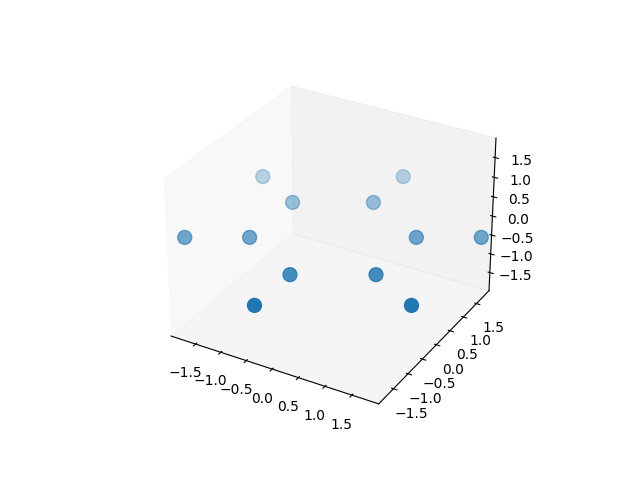

In [44]:
#@title visualize vibrations
#@markdown normal mode : 874.9854802431829
from IPython.display import Image
display(Image(data=open('/content/mode_874.9854802431829.gif','rb').read(), format='png'))

In [41]:
!cat benzene_perturbed.xyz benzene.xyz > comparison.xyz

In [42]:
# overlay plot
# compares original xyz file vs. perturbated xyz file

comparision = OverlayMolecules()
comparision.set_molecules('comparison.xyz')

# change parameter options
comparision.parameters.legend = True
comparision.parameters.atom_scaler = 300
comparision.parameters.bond_scaler = 8200000
comparision.parameters.alpha_bonds = 1
comparision.parameters.alpha_atoms = 1


# plot overlay diagram
comparision.plot_overlay()